In [1]:
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

import overcomplete
from overcomplete.visualization import show, overlay_top_heatmaps 

import torch.nn.functional as F
from tqdm import tqdm

from overcomplete.sae import TopKSAE, train_sae

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import torchvision
from torchvision import transforms

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 3 * 3, 128) 
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))  
        x = self.pool(x)  
        x = F.relu(self.conv2(x)) 
        x = self.pool(x)  
        x = F.relu(self.conv3(x))  
        x = self.pool(x)      
        x = x.view(-1, 128 * 3 * 3)  
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        
        return x

In [3]:
model = SimpleCNN()

In [4]:
!CUDA_VISIBLE_DEVICES=5

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/stu24/s16/ag4077/miniconda3/envs/dev/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


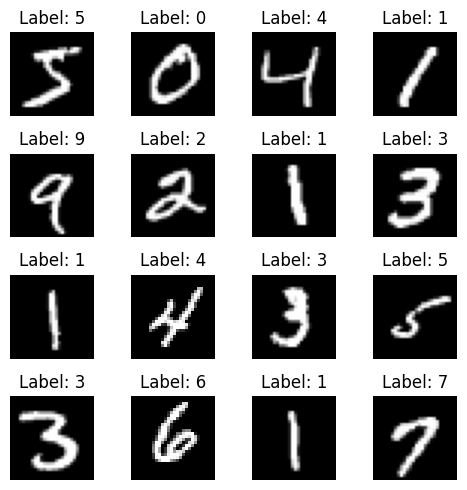

In [6]:
def plot_mnist_samples(dataset, num_images=16):
    plt.figure(figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        plt.subplot(4, 4, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_mnist_samples(train_dataset)

In [7]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/20], Loss: 0.1840
Epoch [2/20], Loss: 0.0486
Epoch [3/20], Loss: 0.0318
Epoch [4/20], Loss: 0.0231
Epoch [5/20], Loss: 0.0192
Epoch [6/20], Loss: 0.0161
Epoch [7/20], Loss: 0.0133
Epoch [8/20], Loss: 0.0107
Epoch [9/20], Loss: 0.0120
Epoch [10/20], Loss: 0.0091
Epoch [11/20], Loss: 0.0093
Epoch [12/20], Loss: 0.0068
Epoch [13/20], Loss: 0.0063
Epoch [14/20], Loss: 0.0077
Epoch [15/20], Loss: 0.0049
Epoch [16/20], Loss: 0.0063
Epoch [17/20], Loss: 0.0041
Epoch [18/20], Loss: 0.0040
Epoch [19/20], Loss: 0.0069
Epoch [20/20], Loss: 0.0044


In [8]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.16%


In [9]:
model.fc2 = nn.Identity()

In [11]:
activations = []
activation_labels = []
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc="Processing Batches", unit="batch")):
        inputs = inputs.to(device)
        activations.append(model(inputs).cpu())  # Move activations to CPU
        activation_labels.append(labels)

Processing Batches: 100%|██████████| 938/938 [00:05<00:00, 179.96batch/s]


In [12]:
Activations = torch.cat(activations, dim=0)

In [13]:
Activations.shape

torch.Size([60000, 128])

In [1]:
sae = TopKSAE(Activations.shape[-1], nb_concepts=10, top_k=2, device='cuda')

dataloader = torch.utils.data.DataLoader(TensorDataset(Activations), batch_size=1024, shuffle=True)
optimizer = torch.optim.Adam(sae.parameters(), lr=5e-4)

def criterion(x, x_hat, pre_codes, codes, dictionary):
  mse = (x - x_hat).square().mean()
  return mse

logs = train_sae(sae, dataloader, criterion, optimizer, nb_epochs=50, device='cuda')

NameError: name 'TopKSAE' is not defined

In [15]:
images, labels = next(iter(train_loader))

In [16]:
images.shape

torch.Size([64, 1, 28, 28])

In [17]:
Activations.shape

torch.Size([60000, 128])

torch.Size([60000, 10])
Concept 0


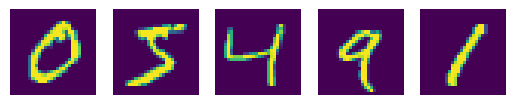

Concept 1


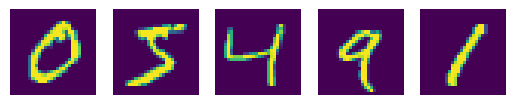

Concept 2


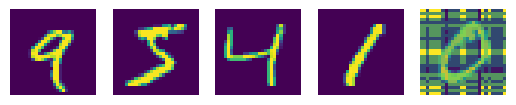

Concept 3


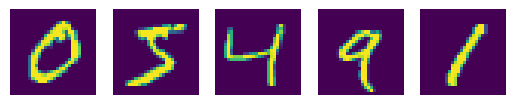

Concept 4


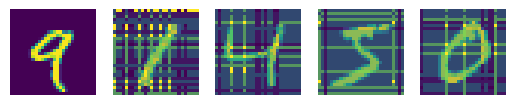

Concept 5


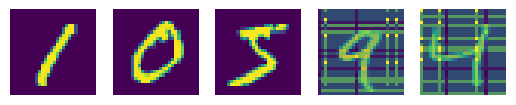

Concept 6


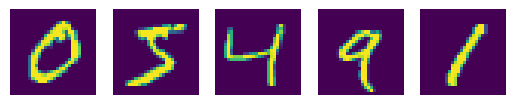

Concept 7


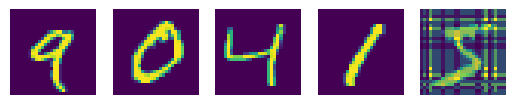

Concept 8


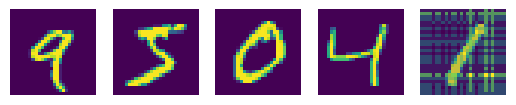

Concept 9


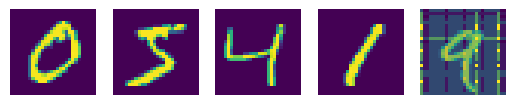

In [18]:
sae = sae.eval()

with torch.no_grad():
  pre_codes, codes = sae.encode(Activations.to(device))


print(codes.shape)

codes = rearrange(codes[:64], '(n w h) d -> n w h d', w=1, h=1)

# print(codes.shape)
# print(images.shape)

for i in range(10):
  print('Concept', i)
  overlay_top_heatmaps(images[:5], codes[:5], concept_id=i)
  plt.show()

In [53]:
pre_codes.shape

torch.Size([128, 10])